<img src="https://avatars.githubusercontent.com/u/61354833" align="left" width="70" height="70">

Code by [TomMakesThings](https://github.com/TomMakesThings/Computational-Intelligence-Genetic-Algorithm)



#**Imports**


In [1]:
!apt-get install poppler-utils
!pip install pdf2image
!pip install pyPDF2
!pip install tika
!pip install jellyfish

from tika import parser
import numpy as np
import os
import glob
import imutils
import cv2
import re
import codecs
import urllib.request
import math
import jellyfish
from PIL import Image
from pdf2image import convert_from_path, convert_from_bytes
from PyPDF2 import PdfFileReader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from skimage.segmentation import clear_border
from skimage.morphology import label
from skimage.measure import regionprops
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plot
import matplotlib.patches as patches
import matplotlib.cm as colourmap
from matplotlib.pyplot import imread

# Uses the same random numbers across runs
np.random.seed(0)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 1s (300 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 148492 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 77 kB 3.2 MB/s 
  Created wheel for pyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61101 sha256=4da0d1d1826df53a23a665a21a77ce1c302cecc

# **Functions**

In [2]:
def downloadFile(url, file_name, folder):
  """ Open a file given by a URL and save the file locally """
  
  # Open the URL
  response = urllib.request.urlopen(url)
  # Make the folder if it does not exist
  if not os.path.isdir(folder):
    os.mkdir(folder)
  # Write the contents to file
  file = open(os.path.join(folder, file_name), 'wb')
  file.write(response.read())
  file.close()

In [3]:
def plotLetters(letter_images, n_cols, fig_size = (18, 18)):
  """ Takes a list of images, such as characters found in bounding boxes, and plots them as subplots """

  # Dynamically calculate the number of rows
  n_rows = math.ceil(len(letter_images) / n_cols)
  if (len(letter_images) % n_cols == 0):
    n_rows += 1

  # Plot each character as a subplot
  fig, axs = plot.subplots(n_rows, n_cols, figsize = fig_size)
  for i in range(len(letter_images)):
    ax = axs[int(i / n_cols)][i % n_cols]
    ax.imshow(letter_images[i])
  fig.tight_layout()

  # Hide unused axes
  for j in range(1, n_cols - (len(letter_images) % n_cols) + 1):
      axs[-1, -1 * j].axis('off')
      
  return fig

In [4]:
def extractLetters(image, show = False, blur = True, order = True):
    """ Extracts letters from an image and returns an array of images of the letters """

    if blur == True:
      if show == True:
        figure, axes = plot.subplots(ncols=3, nrows=2, figsize=(16, 14))
        axes[0][0].imshow(image)
        axes[0][0].set_title("Original Image")

      # Adds padding to image to increase edge around letters
      image = cv2.copyMakeBorder(image, 15, 15, 15, 15, cv2.BORDER_CONSTANT, value = [255,255,255])

      # Applies gaussian blur to merge dots in letters such as i and j
      # Kernel size must be odd
      # Small amount of blur in x direction
      # Large blur in y direction
      blurred = cv2.GaussianBlur(image, (33, 35), 0)

      # Converts to 1 colour channel before threshing
      gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

      # Assigns pixel values if pixel values fall outside of the threshold
      selected_threshold, threshed = cv2.threshold(gray, 10, 255, cv2.THRESH_OTSU)

      # Reverts back to 3 colour channels
      three_channel = np.zeros_like(blurred)
      three_channel[:,:,0] = threshed
      three_channel[:,:,1] = threshed
      three_channel[:,:,2] = threshed

      if show == True:
        axes[0][1].imshow(image)
        axes[0][1].set_title("Padded")
        axes[0][2].imshow(blurred)
        axes[0][2].set_title("Gaussian Blur")
        axes[1][0].imshow(gray)
        axes[1][0].set_title("Converted to 1 Colour Channel")
        axes[1][1].imshow(three_channel)
        axes[1][1].set_title("Otsu Adaptive Thresholding")

      # Apply threshold to convert the image into boolean values
      boolean_image = blurred < 200

    else:
      # Threshold image without blur
      boolean_image = image < 200

    copy_image = boolean_image.copy()
    # Blurs image to merge letters with dots
    blurred = copy_image
    # Clears objects connected to the image border
    clear_border(blurred)

    # Label image regions
    label_image = label(blurred, connectivity=2)
    borders = np.logical_xor(boolean_image, blurred)
    label_image[borders] = -1

    if show == True:
      if blur == True:
        axes[1][2].imshow(image)
        axes[1][2].set_title("Bounding Boxes")
      else:
        # Plots the image onto a graph
        figure, axes = plot.subplots(ncols=1, nrows=1, figsize=(6, 6))
        axes.imshow(image)

    # Stores letters extracted
    ROIs = []
    # Stores all detected regions
    regions = []
    final = []

    for region in regionprops(label_image):
      # Skip small images
      if region.area > 25:
        # Coordinates of rectangle
        y_bottom = region.bbox[0]
        x_left = region.bbox[1]
        y_top = region.bbox[3]
        x_right = region.bbox[4]
        regions.append([y_bottom, x_left, y_top, x_right])

    if order == True:
      # Sort the detected characters left to right, top to bottom
      lines = []
      first_in_line = ''
      counter = 0

      # Worst case scenario there can be 1 character per line
      for x in range(len(regions)):
          lines.append([])
    
      for character in regions:
          if first_in_line == '':
              first_in_line = character
              lines[counter].append(character)
          elif abs(character[0] - first_in_line[0]) < (first_in_line[2] - first_in_line[0]):
              lines[counter].append(character)
          elif abs(character[0] - first_in_line[0]) > (first_in_line[2] - first_in_line[0]):
              first_in_line = character
              counter += 1
              lines[counter].append(character)

      for x in range(len(lines)):       
          lines[x].sort(key=lambda tup: tup[1])

      prev_tr = 0
      prev_line_br = 0
        
      for i in range(len(lines)):
          for j in range(len(lines[i])):
              tl_2 = lines[i][j][1]
              bl_2 = lines[i][j][0]
              if tl_2 > prev_tr and bl_2 > prev_line_br:
                  final.append(lines[i][j])
                  prev_tr = lines[i][j][3]
              if j == (len(lines[i])-1):
                  prev_line_br = lines[i][j][2]
          prev_tr = 0
          tl_2 = 0

    # Prevents errors if regions are not sorted
    if not final:
      final = regions

    for region in final:
      if show == True:
        # Draw box around letter
        box = patches.Rectangle((region[1], region[0]), region[3] - region[1], region[2] - region[0],
                                fill = False, edgecolor = 'blue', linewidth = 1)
        if blur == True:
          axes[1][2].add_patch(box)
        else:
          # Adds the box to the graph
          axes.add_patch(box)

      # Region of interest in image
      ROI = image[region[0]:region[2], region[1]:region[3]]
      ROIs.append(ROI)

    if show == True:
      plot.show()
      figure, axes = plot.subplots(ncols=2, nrows=1, figsize=(10, 5))
      axes[0].imshow(ROIs[0])
      axes[0].set_title("Region of Interest (ROI)")

    # Resizes letters to be 20 x 20 pixels
    for i in range(len(ROIs)):
      img = ROIs[i]
      img = cv2.resize(img, (20, 20), interpolation = cv2.INTER_AREA)

      # Converts to 1 colour channel before threshing
      grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      # Assigns pixel values if pixel values fall outside of the threshold
      selected_threshold, threshed = cv2.threshold(grey, 50, 255, cv2.THRESH_BINARY)
      threshed = cv2.cvtColor(threshed,cv2.COLOR_GRAY2RGB)

      ROIs[i] = threshed

    if show == True:
      axes[1].imshow(ROIs[0])
      axes[1].set_title("Binary Threshold")
      plot.show()

    return ROIs

In [5]:
def getLabelsFromTXT(file_paths):
  """ Takes a list of txt file paths and return the text for each in a list """
  
  labels = []
  for i in range(len(file_paths)):
    # Each line is stored separately
    fileLines = []
    with codecs.open(file_paths[i], 'r') as f:
      for line in f:
        # Removes spaces
        line = line.replace(" ","")
        if len(line) > 0:
          line = line.rstrip()
          # Converts to lower case
          line = line.lower()
          fileLines.append(line)
    labels.append(fileLines)
  return labels

# **Download Data**

Either download training and testing data from [GitHub](https://github.com/TomMakesThings/Sinhala-Optical-Character-Recognition) by setting `read_from_URL` as `True`, or set as `False` to all read files from a local path.
* PDFs are to be converted to images to be used as input for the OCR system
* Text files contain the expected output text

In [6]:
training_directory = 'https://github.com/TomMakesThings/Sinhala-Optical-Character-Recognition/raw/main/Training'
testing_directory = 'https://github.com/TomMakesThings/Sinhala-Optical-Character-Recognition/raw/main/Testing'

read_from_URL = True

if read_from_URL:
  # Dictionary linking PDFs with their matching text files
  training_data_dict = {"SinhalaAlphabetBold.pdf": "SinhalaAlphabet.txt",
                        "SinhalaAlphabet.pdf": "SinhalaAlphabet.txt"}
  testing_data_dict = {"SinhalaTest.pdf": "SinhalaTest.txt"}

  training_file_paths, testing_file_paths = [], []
  training_txt_paths, testing_txt_paths = [], []

  # Download the PDF and txt training data from URL
  for train_pdf in training_data_dict:
      try:
        # Read PDFs
        downloadFile(url = training_directory + "/" + train_pdf, 
                     file_name = train_pdf, 
                     folder = "Train")
        training_file_paths.append("Train/" + train_pdf)
      except IOError as exc:
        raise RuntimeError("File not found: failed to open training data PDF file " + training_directory + "/" + train_pdf) from exc
      try:
        # Read txt
        downloadFile(url = training_directory + "/" + training_data_dict[train_pdf], 
                     file_name = training_data_dict[train_pdf], 
                     folder = "Train")
        training_txt_paths.append("Train/" + training_data_dict[train_pdf])
      except IOError as exc:
        raise RuntimeError("File not found: failed to open training data text file " + training_directory + "/" + training_data_dict[train_pdf]) from exc
  
  # Download the PDF and txt testing data from URL
  for test_pdf in testing_data_dict:
      try:
        downloadFile(url = testing_directory + "/" + test_pdf, 
                     file_name = test_pdf, 
                     folder = "Test")
        testing_file_paths.append("Test/" + test_pdf)
      except IOError as exc:
        raise RuntimeError("File not found: failed to open testing data PDF file " + testing_directory + "/" + test_pdf) from exc
      try:
        downloadFile(url = testing_directory + "/" + testing_data_dict[test_pdf], 
                     file_name = testing_data_dict[test_pdf], 
                     folder = "Test")
        testing_txt_paths.append("Test/" + testing_data_dict[test_pdf])
      except IOError as exc:
        raise RuntimeError("File not found: failed to open testing data text file " + testing_directory + "/" + testing_data_dict[test_pdf]) from exc
else:
  # Find all the PDF / text files from local directories
  training_file_paths = glob.glob(training_directory + '/*.pdf')
  testing_file_paths = glob.glob(testing_directory + '/*.pdf')
  training_txt_paths = glob.glob(training_directory + '/*.txt')
  testing_txt_paths = glob.glob(testing_directory + '/*.txt')

print("Training PDFs:", training_file_paths)
print("Training text:", training_txt_paths)
print("Testing PDFs:", testing_file_paths)
print("Testing text:", testing_txt_paths)

Training PDFs: ['Train/SinhalaAlphabetBold.pdf', 'Train/SinhalaAlphabet.pdf']
Training text: ['Train/SinhalaAlphabet.txt', 'Train/SinhalaAlphabet.txt']
Testing PDFs: ['Test/SinhalaTest.pdf']
Testing text: ['Test/SinhalaTest.txt']


# **Training**

Extract the labels from the text files to use as a ground truth

In [7]:
# Get letters from training images
training_text_labels = []

training_text_labels = getLabelsFromTXT(training_txt_paths)

for i in range(len(training_text_labels)):
  print("Labels for training file", str(i + 1) + ":", training_text_labels[i])

Labels for training file 1: ['ඊඅආඇඈඉඋඌඍඎඏඐඑඒඓඔඕඖකඛගඝඞඟචඡජඣඤඦටඨඩඪණඬතථදධනඳපඵබභමඹයරලවශෂසහළෆ']
Labels for training file 2: ['ඊඅආඇඈඉඋඌඍඎඏඐඑඒඓඔඕඖකඛගඝඞඟචඡජඣඤඦටඨඩඪණඬතථදධනඳපඵබභමඹයරලවශෂසහළෆ']


Extract character images for training the OCR model:
* Convert each PDF to an image
* Add padding to the image to increase edge around the characters and apply a Gaussian blur
* Convert the image from colour to grayscale
* Apply an Otsu threshold
* Segment the characters in the image using bounding boxes
* Sort each character by x coordinate
* Resize each character to 20 × 20 pixels
* Apply a binary threshold

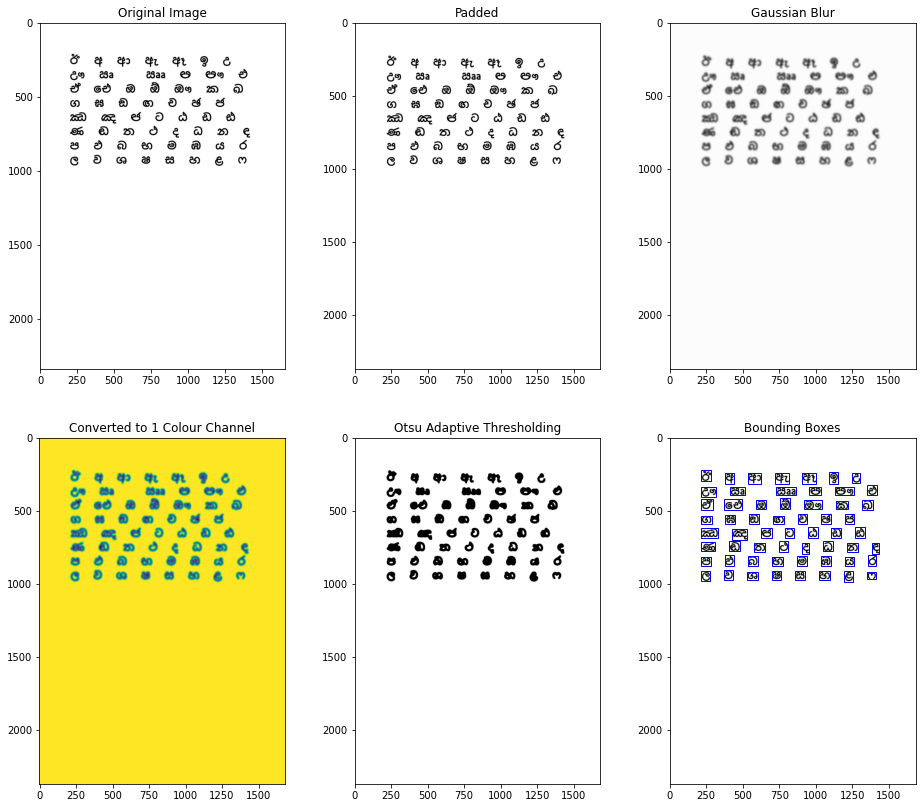

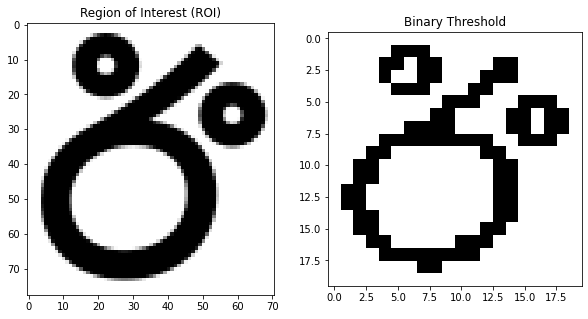

In [8]:
# 2 dimensional array storing the letter images extracted from each training image
training_image_letters = []

# Finds characters / letters in each image
for i in range(len(training_file_paths)):
  # Converts pdf to image
  image = convert_from_path(training_file_paths[i])
  # Converts from PIL image to open cv image
  image = np.array(image[0])

  ROIs = []
  if i == 0:
    # Displays the results of the first image
    ROIs.append(extractLetters(image, show = True))
  else:
    ROIs.append(extractLetters(image, show = False))
  training_image_letters.insert(i, ROIs)

Plot the characters extracted from the first training PDF
* To see other PDFs, changed `idx` in `training_image_letters[idx][0]`

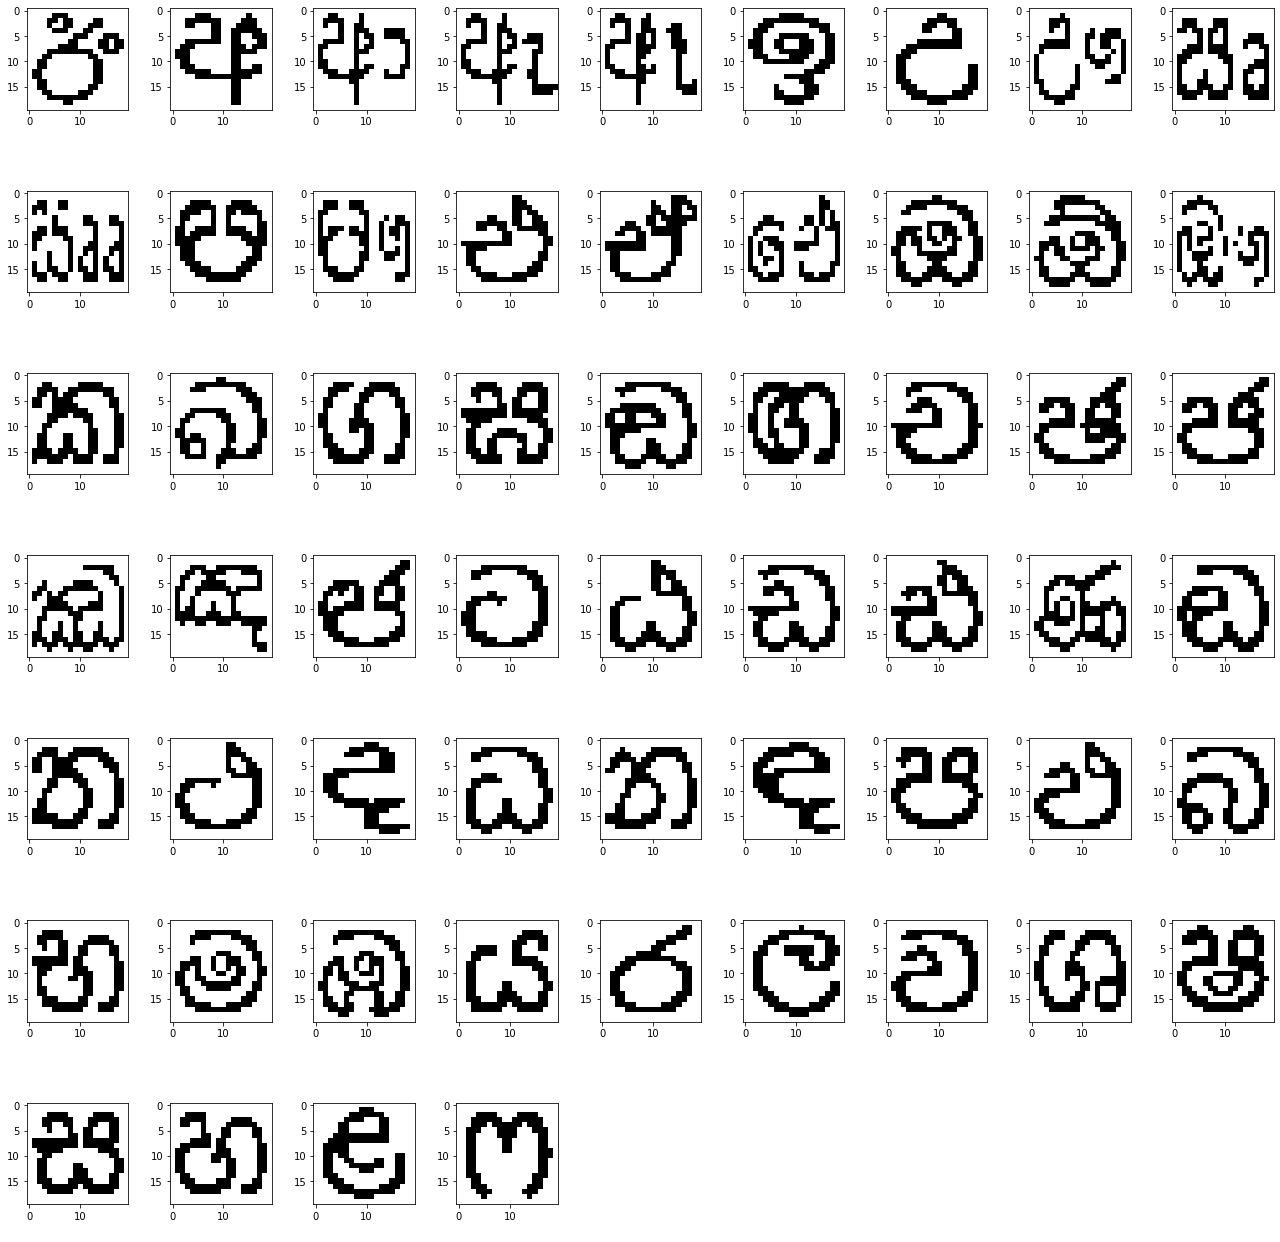

In [9]:
fig = plotLetters(letter_images = training_image_letters[0][0],
                  n_cols = 9,
                  fig_size = (18, 18))

Converts training letter images and labels into a form suitable for the classifier
* Prints the first characters from each training PDF

ඊ
ඊ
Number of train images: 116
Number of train labels: 116


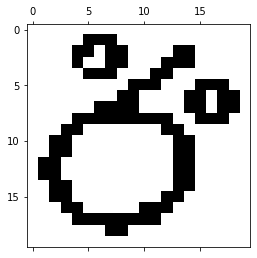

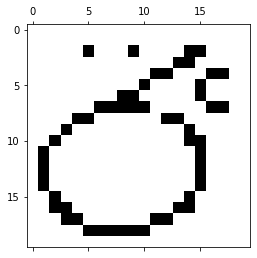

In [10]:
# Training letter images
x_train = []
# Training labels
y_train = []

# Iterates through every file
for i in range(len(training_text_labels)):
  # Iterates through every line in a file
  for j in range(len(training_text_labels[i])):
    # Ensures that number of images and labels are the same to prevent errors
    number_of_images = len(training_image_letters[i][j])
    number_of_labels = len(training_text_labels[i][j])
    if number_of_images > number_of_labels:
      # Removes extra images from a line
      training_image_letters[i][j] = training_image_letters[i][j][:number_of_labels]
      print("Warning: More images found than labels")
    elif number_of_labels > number_of_images:
      training_text_labels[i][j] = training_text_labels[i][j][:number_of_images]
      print("Warning: Less images found than labels")

    if number_of_images != 0:
      for k in range(len(training_image_letters[i][j])):
        letter = training_text_labels[i][j][k]
        image = training_image_letters[i][j][k]
        # Displays a letter
        if j == 0 and k == 0:
          print(letter)
          plot.matshow(image)
          plot.show
        # Converts image to black and white
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Array to hold image data
        # Data is extracted from 2-dimensional array to a 1-dimensional array
        data = []
        # Iterates through rows in image
        for x in range(len(image)):
          for y in image[x]:
            # Adds all row values to one array
            data.append(y)
        x_train.append(data)
        y_train.append(letter)

# Converts from list to numpy array
x_train = np.asarray(x_train)
print("Number of train images:", len(x_train))

y_train = np.asarray(y_train)
print("Number of train labels:", len(y_train))

# **Testing**

Extract the labels from the text files

In [11]:
# Get letters from testing images
testing_text_labels = []

testing_text_labels = getLabelsFromTXT(testing_txt_paths)

for i in range(len(testing_text_labels)):
  print(testing_text_labels[i])

['ථළභඦඹශඝඖරඨෆඦඤදධඣඏඋඏධටඝෆඵයවෂෂඉආකචඤඏ']


Extract the letters from the testing images

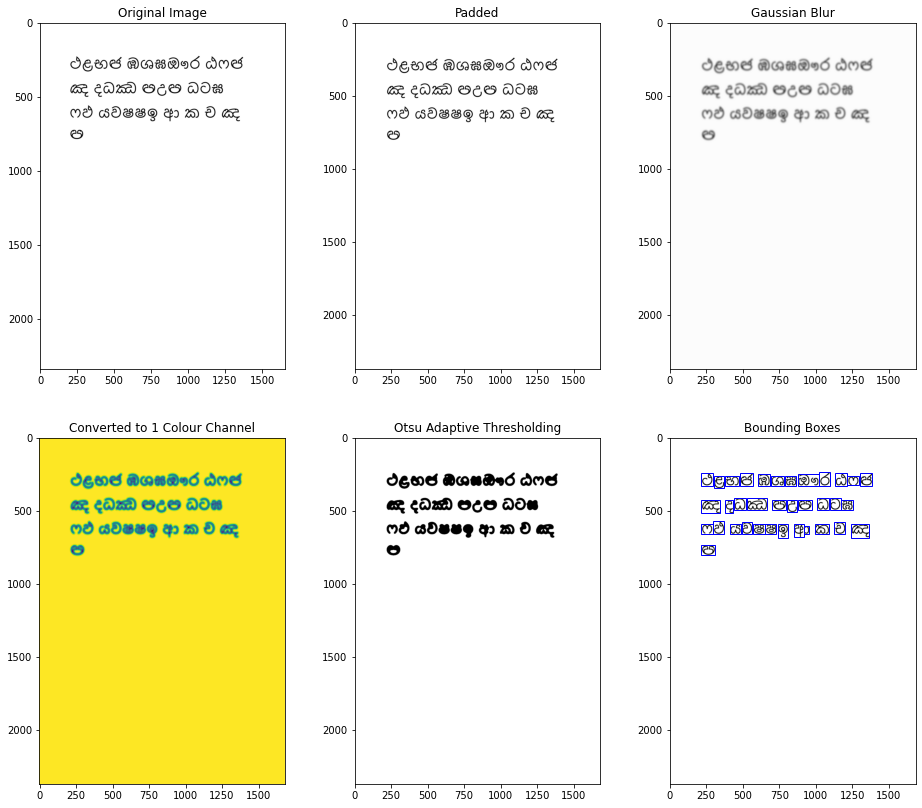

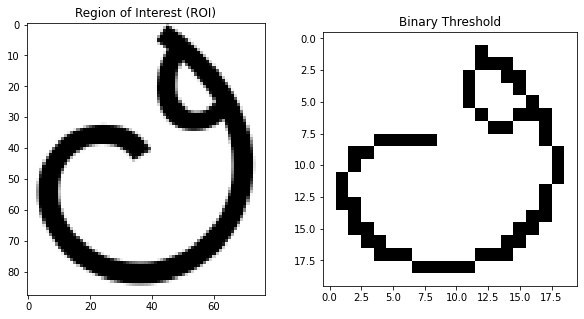

In [21]:
# 2 dimensional array storing the letter images extracted from each testing image
testing_image_letters = []

# Finds letters in each image
for i in range(len(testing_file_paths)):
  # Converts pdf to image
  image = convert_from_path(testing_file_paths[i])
  # Converts from PIL image to open cv image
  image = np.array(image[0])

  ROIs = []
  if i == 0:
    # Displays the results of the first image
    ROIs.append(extractLetters(image, show = True))
  else:
    ROIs.append(extractLetters(image, show = False))
  testing_image_letters.insert(i, ROIs)

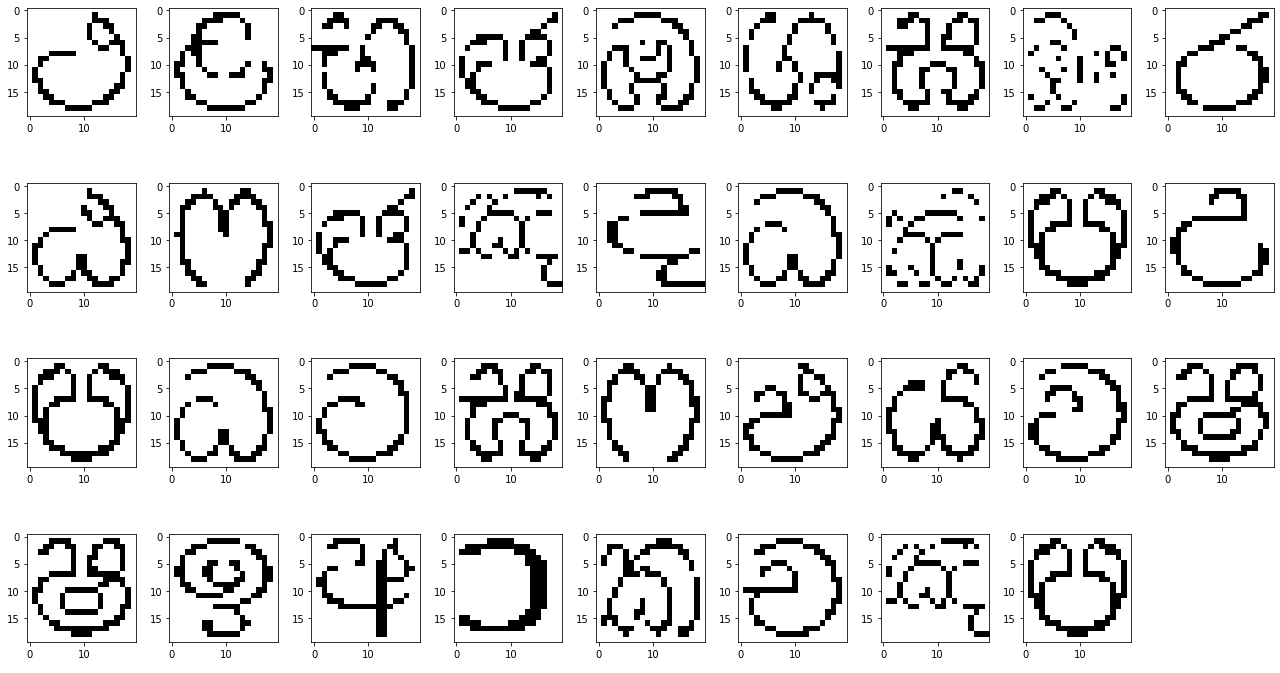

In [13]:
fig = plotLetters(letter_images = testing_image_letters[0][0],
                  n_cols = 9,
                  fig_size = (18, 10))

Convert the testing character images into a form suitable for the classifier

ථ
Number of test images: 34
Number of test labels: 34


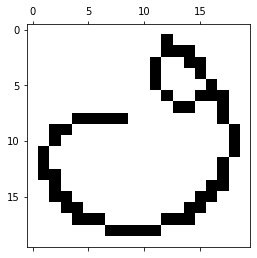

In [14]:
# Testing letter images
x_test = []
# Testing labels
y_test = []


# Iterates through every file
for i in range(len(testing_text_labels)):
  # Iterates through every line in a file
  for j in range(len(testing_text_labels[i])):
    # Ensures that number of images and labels are the same to prevent errors
    number_of_images = len(testing_image_letters[i][j])
    number_of_labels = len(testing_text_labels[i][j])
    if number_of_images > number_of_labels:
      # Removes extra images from a line
      testing_image_letters[i][j] = testing_image_letters[i][j][:number_of_labels]
    elif number_of_labels > number_of_images:
      testing_text_labels[i][j] = testing_text_labels[i][j][:number_of_images]

    if number_of_images != 0:
      for k in range(len(testing_image_letters[i][j])):
        letter = testing_text_labels[i][j][k]
        image = testing_image_letters[i][j][k]
        # Displays a letter
        if j == 0 and k == 0:
          print(letter)
          plot.matshow(image)
          plot.show
        # Converts image to black and white
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Array to hold image data
        # Data is extracted from 2-dimensional array to a 1-dimensional array
        data = []
        # Iterates through rows in image
        for x in range(len(image)):
          for y in image[x]:
            # Adds all row values to one array
            data.append(y)
        x_test.append(data)
        y_test.append(letter)

# Converts from list to numpy array
x_test = np.asarray(x_test)
print("Number of test images:", len(x_test))

y_test = np.asarray(y_test)
print("Number of test labels:", len(y_test))

# **KNN Classifier**

Train the K-Nearest Neighbors (KNN) classifier and make a prediction on the test data

In [15]:
# The classifier:
# - Weigh points by the inverse of their distance
# - 5 neighbours
# - Uses all processors to run jobs in parallel
KNN_classifier = KNeighborsClassifier(weights = 'distance', n_neighbors = 5, n_jobs = -1)

# x_train is the training data set
# y_train is the labels for data in x_train
KNN_classifier.fit(x_train, y_train)

# x_test is the test data set
KNN_prediction = KNN_classifier.predict(x_test)

# **Performance Metrics**

Print the predicted text and the expected text

In [16]:
pred_text = ""
true_text = ""

for c in KNN_prediction:
  pred_text = pred_text + c

true_text = true_text.join(list(y_test))

print("Prediction:", pred_text)
print("Actual:    ", true_text)

Prediction: ථළභඦඹශඝඖරඨෆඦඤදධඣඏඋඏධටඝෆඵයවෂෂඉඅටකචඤ
Actual:     ථළභඦඹශඝඖරඨෆඦඤදධඣඏඋඏධටඝෆඵයවෂෂඉආකචඤඏ


Calculate the Levenshtein distance and Jaro-Winkler distance to measure the difference between the predicted labels and the expected labels

In [22]:
levenshtein = jellyfish.levenshtein_distance(pred_text, true_text)
jaro = round(jellyfish.jaro_distance(pred_text, true_text), 3)

print("Levenshtein distance:", levenshtein)
print("Jaro–Winkler distance:", jaro)

Levenshtein distance: 3
Jaro–Winkler distance: 0.961


Calculate a cross-validation across different folds

In [18]:
# Breaks data set into 2 folds and makes predictions
cross_val_score(KNN_classifier, x_train, y_train, cv=2, scoring="accuracy")

array([0.84482759, 0.89655172])

Plot a confusion matrix to visualise the characters the KNN got incorrect during training

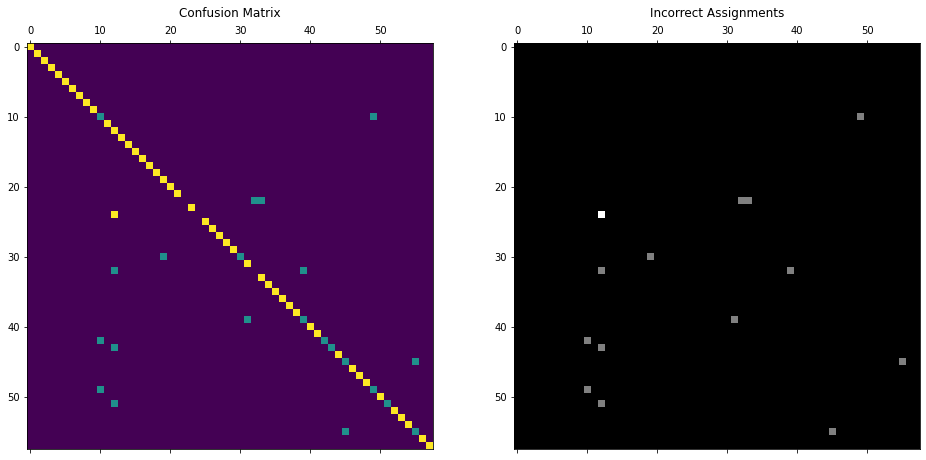

In [19]:
# Calculate confusion matrix values
y_train_pred = cross_val_predict(KNN_classifier, x_train, y_train, cv=2)
conf_mx = confusion_matrix(y_train, y_train_pred)

# Identify incorrect values
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig, (ax1, ax2) = plot.subplots(1, 2, figsize=(16, 16))
ax1.matshow(conf_mx)
ax1.set_title('Confusion Matrix')
ax2.matshow(norm_conf_mx, cmap=plot.cm.gray)
ax2.set_title('Incorrect Assignments')
plot.show()

Compare different values for K to optimise KNN
* Plots the relationship between K, average cross validation score and testing accuracy

K value: [0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882, 0.8529411764705882]
Cross validation average: [0.8706896551724138, 0.8706896551724138, 0.8706896551724138, 0.8706896551724138, 0.8706896551724138, 0.8706896551724138, 0.8706896551724138, 0.8706896551724138, 0.8706896551724138]



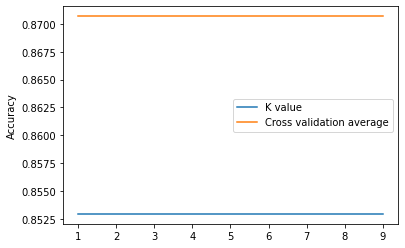

In [20]:
k_scores = []
cross_scores = []
k_range = range(1, 10)

for k in k_range:
  KNN_classifier = KNeighborsClassifier(n_jobs = -1, weights = 'distance', n_neighbors = k)
  KNN_classifier.fit(x_train, y_train)
  KNN_prediction = KNN_classifier.predict(x_test)
  k_scores.append(accuracy_score(y_test, KNN_prediction))
  cross = cross_val_score(KNN_classifier, x_train, y_train, cv=2, scoring="accuracy")
  # Calculates average
  cross_scores.append(sum(cross) / len(cross))

print("K value: " + str(k_scores))
print("Cross validation average: " + str(cross_scores))
print("")

# Plot the relationship between K, average cross validation score and testing accuracy
plot.plot(k_range, k_scores, label='K value')
plot.plot(k_range, cross_scores, label='Cross validation average')
plot.ylabel('Accuracy')
plot.legend()
plot.show()